In [16]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [17]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[10.06376669  9.63391276  9.39582886  9.22513415  8.81750957  8.32179518
  7.83460912  7.85188512  7.54667311  7.48145039  7.11961375  6.99227252
  6.58293248  6.39531078  6.04660235  5.69082375  5.48378291  5.217612
  4.99342317  4.73428717  4.51302559  4.35228676  4.11629688  3.88418267
  3.55573832  3.50006786  3.41128641  3.25844672  3.04274136  2.94558568
  2.84015405  2.73372914  2.58696734  2.42038737  2.24910538  2.26218921
  2.120283    2.01078965  2.06121323  1.98128115  1.94598947  1.87480666
  1.81104942  1.72455791  1.69099823  1.61511609  1.5833193   1.43808901
  1.50727403  1.43788038  1.38573987  1.36747943  1.26581002  1.2495099
  1.2437343   1.25383412  1.22371361  1.18003178  1.12343224  1.17349904
  1.11860404  1.10021589  1.06719258  0.96709617  0.99673216  1.00965341
  1.00919522  0.93829633  0.97626841  0.90657322  0.86890736  0.81357237
  0.75714926  0.77142725  0.79693162  0.72143953  0.77942286  0.6609652 ]
[2.34  2.265 2.28  2.37  2.345 2.235 2.17  2.23  2.23

Add noise to the data (using random sampling from normal distribution)

In [18]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [19]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [20]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_324/1430441265.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [21]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     543     0:01.4
2     1053    0:02.8
3     1581    0:04.3
20    8673    0:24.2
40    14730   0:42.3
60    20427   0:59.3
80    26415   1:17.3
100   32217   1:34.8
120   38037   1:52.2
140   43824   2:09.6
160   49746   2:27.4
180   55515   2:44.7
200   61263   3:03.7
220   67110   3:21.0
240   73104   3:39.5
260   78777   3:59.3
280   84789   4:19.3
300   90729   4:37.8
320   96615   4:57.3
340   102555   5:17.5
360   108486   5:38.1
380   114630   6:00.1
400   120528   6:21.0
420   126831   6:44.5
440   132696   7:06.5
460   138645   7:29.3
480   144534   7:52.2
500   150462   8:15.0
520   156612   8:40.5
540   162558   9:05.5
560   168708   9:29.4
580   174143   9:51.3
600   176631  10:02.7
Halting: Maximum number of iterations (600) reached.
[[[2.70000000e-04 8.10000000e+02 9.00000000e-01 ... 9.00000000e-01
   9.00000000e-01 9.00000000e-01]
  [4.19817534e-0

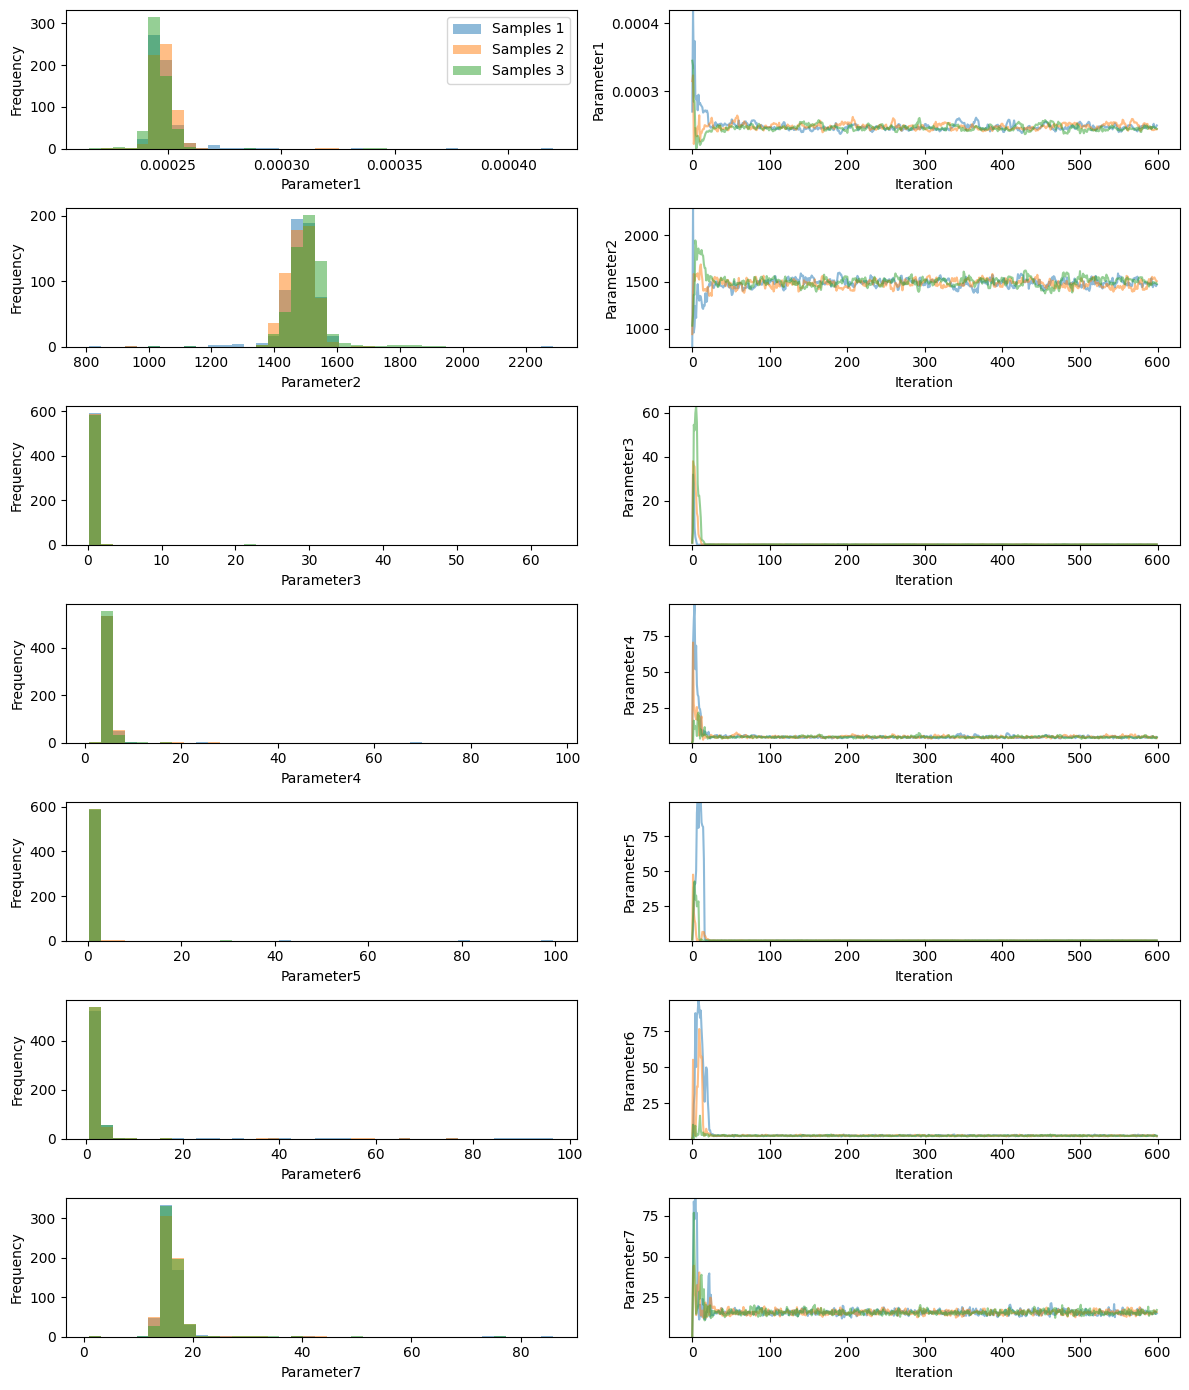

In [32]:

pints.plot.trace(chains)
plt.savefig("mcmc.png")
plt.show()


In [23]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(500, 7)
[2.47383658e-04 1.50121830e+03 2.79642776e-01 5.53365404e+00
 3.62598131e-01 2.76647959e+00 1.63517975e+01]
[[2.47383658e-04 1.50121830e+03 2.79642776e-01 ... 3.62598131e-01
  2.76647959e+00 1.63517975e+01]
 [2.47331855e-04 1.50448967e+03 2.54779927e-01 ... 3.75474495e-01
  2.40716655e+00 1.43680095e+01]
 [2.47306179e-04 1.52402332e+03 2.50149835e-01 ... 3.95710033e-01
  2.75458832e+00 1.46373935e+01]
 ...
 [2.46505931e-04 1.47391465e+03 2.56277661e-01 ... 4.53731058e-01
  3.11709765e+00 1.63778049e+01]
 [2.47604054e-04 1.45563402e+03 2.62733869e-01 ... 4.21259381e-01
  2.66639783e+00 1.48243861e+01]
 [2.49588993e-04 1.47047602e+03 2.36720795e-01 ... 3.60667474e-01
  2.33962060e+00 1.52821489e+01]]


In [24]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


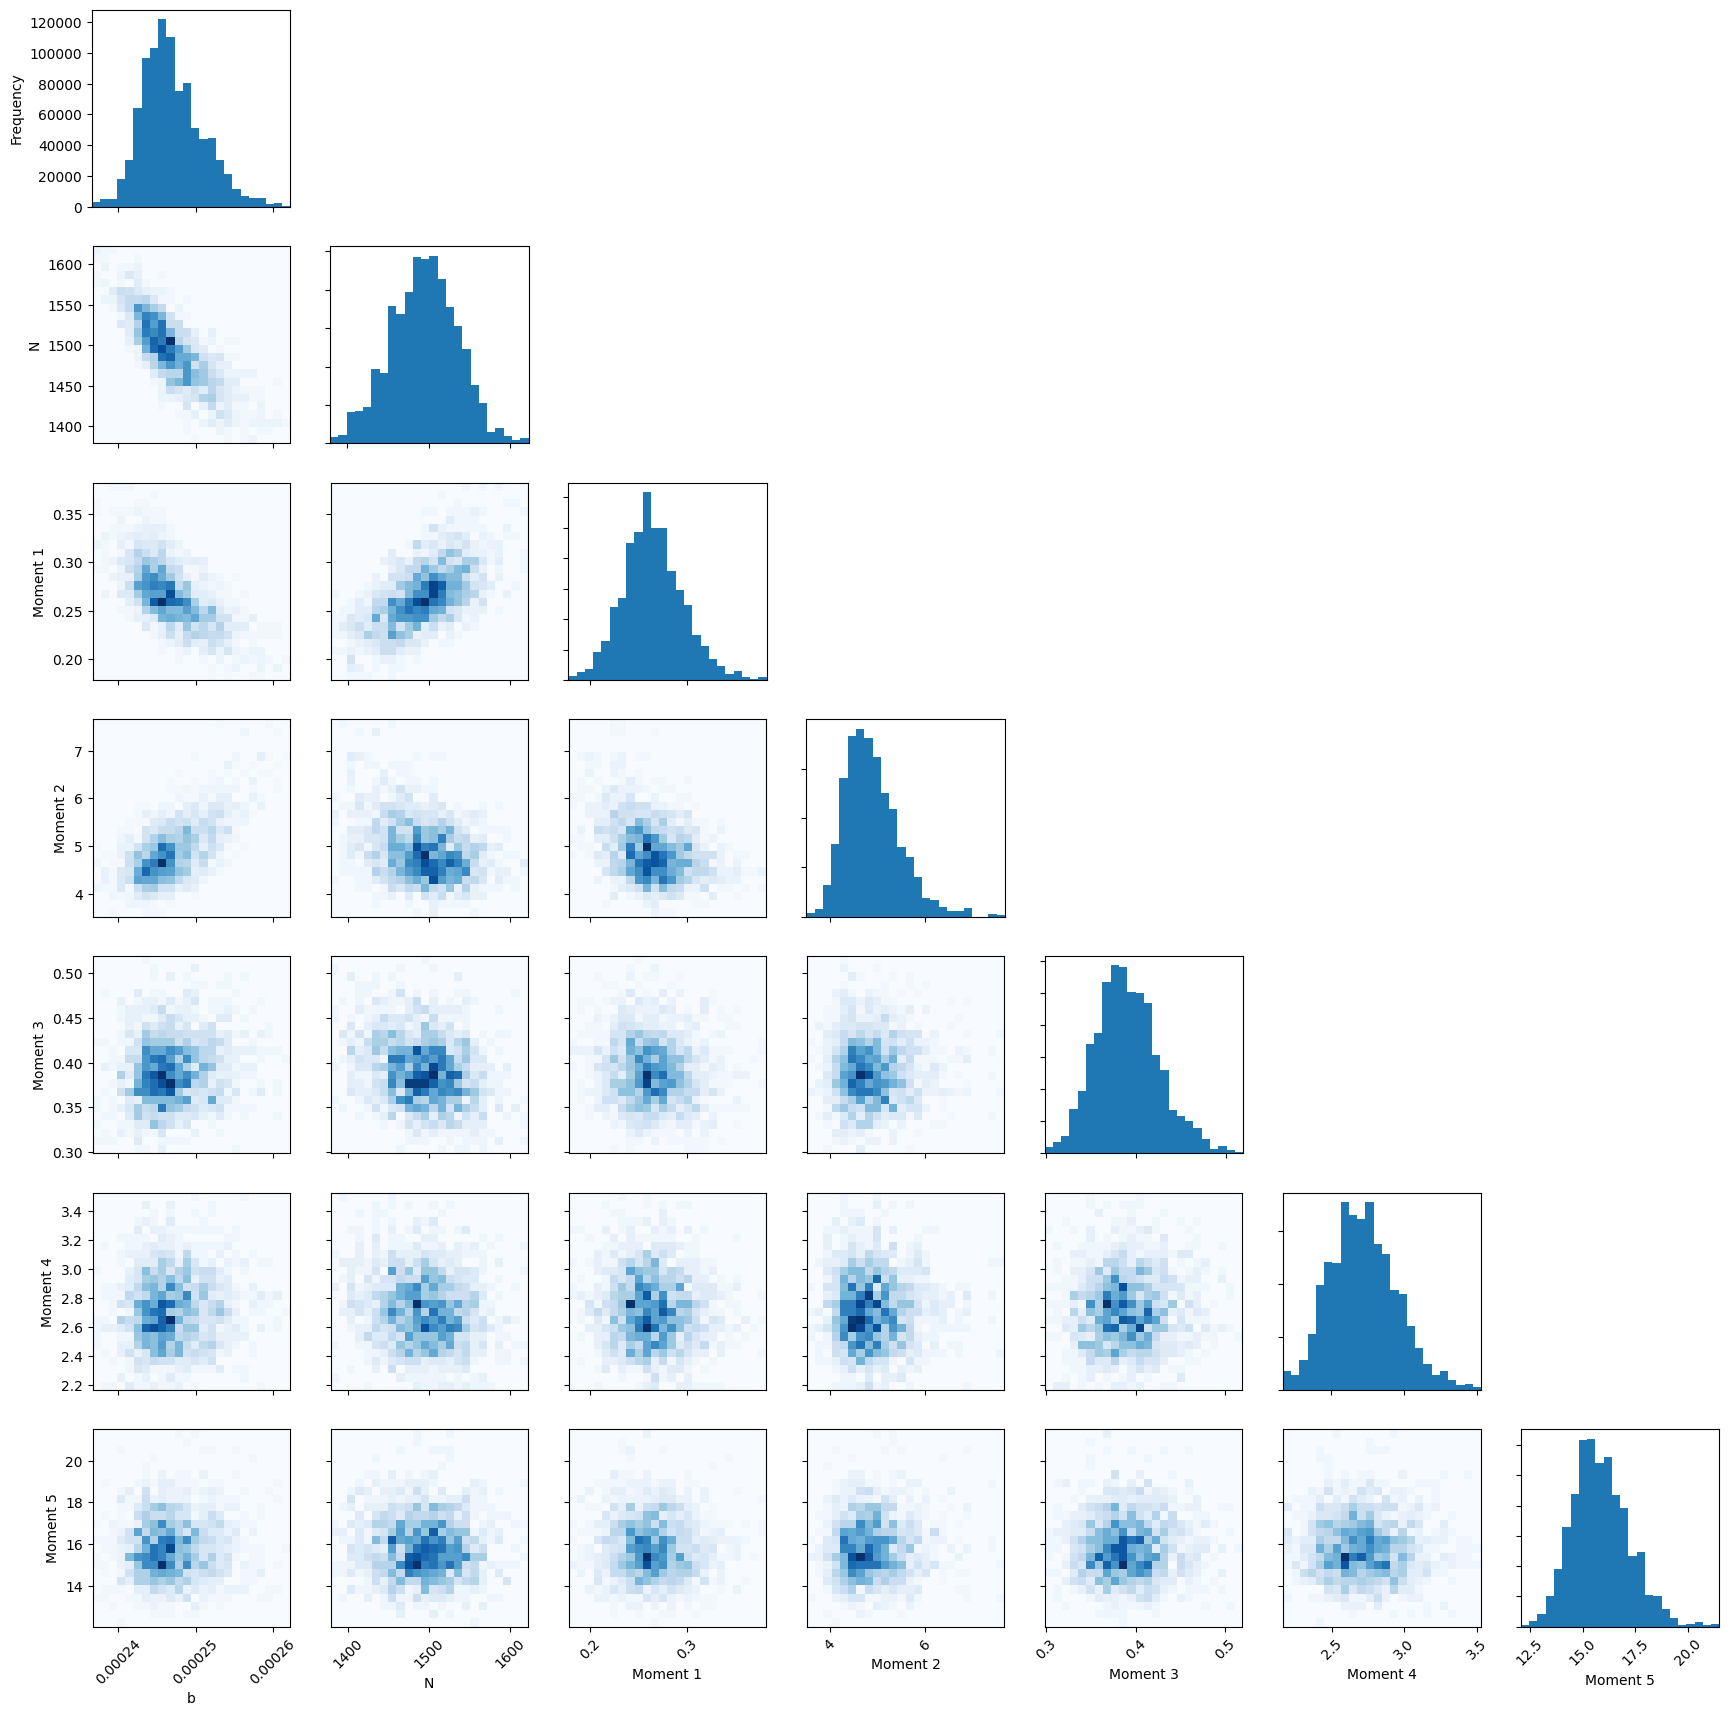

In [25]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

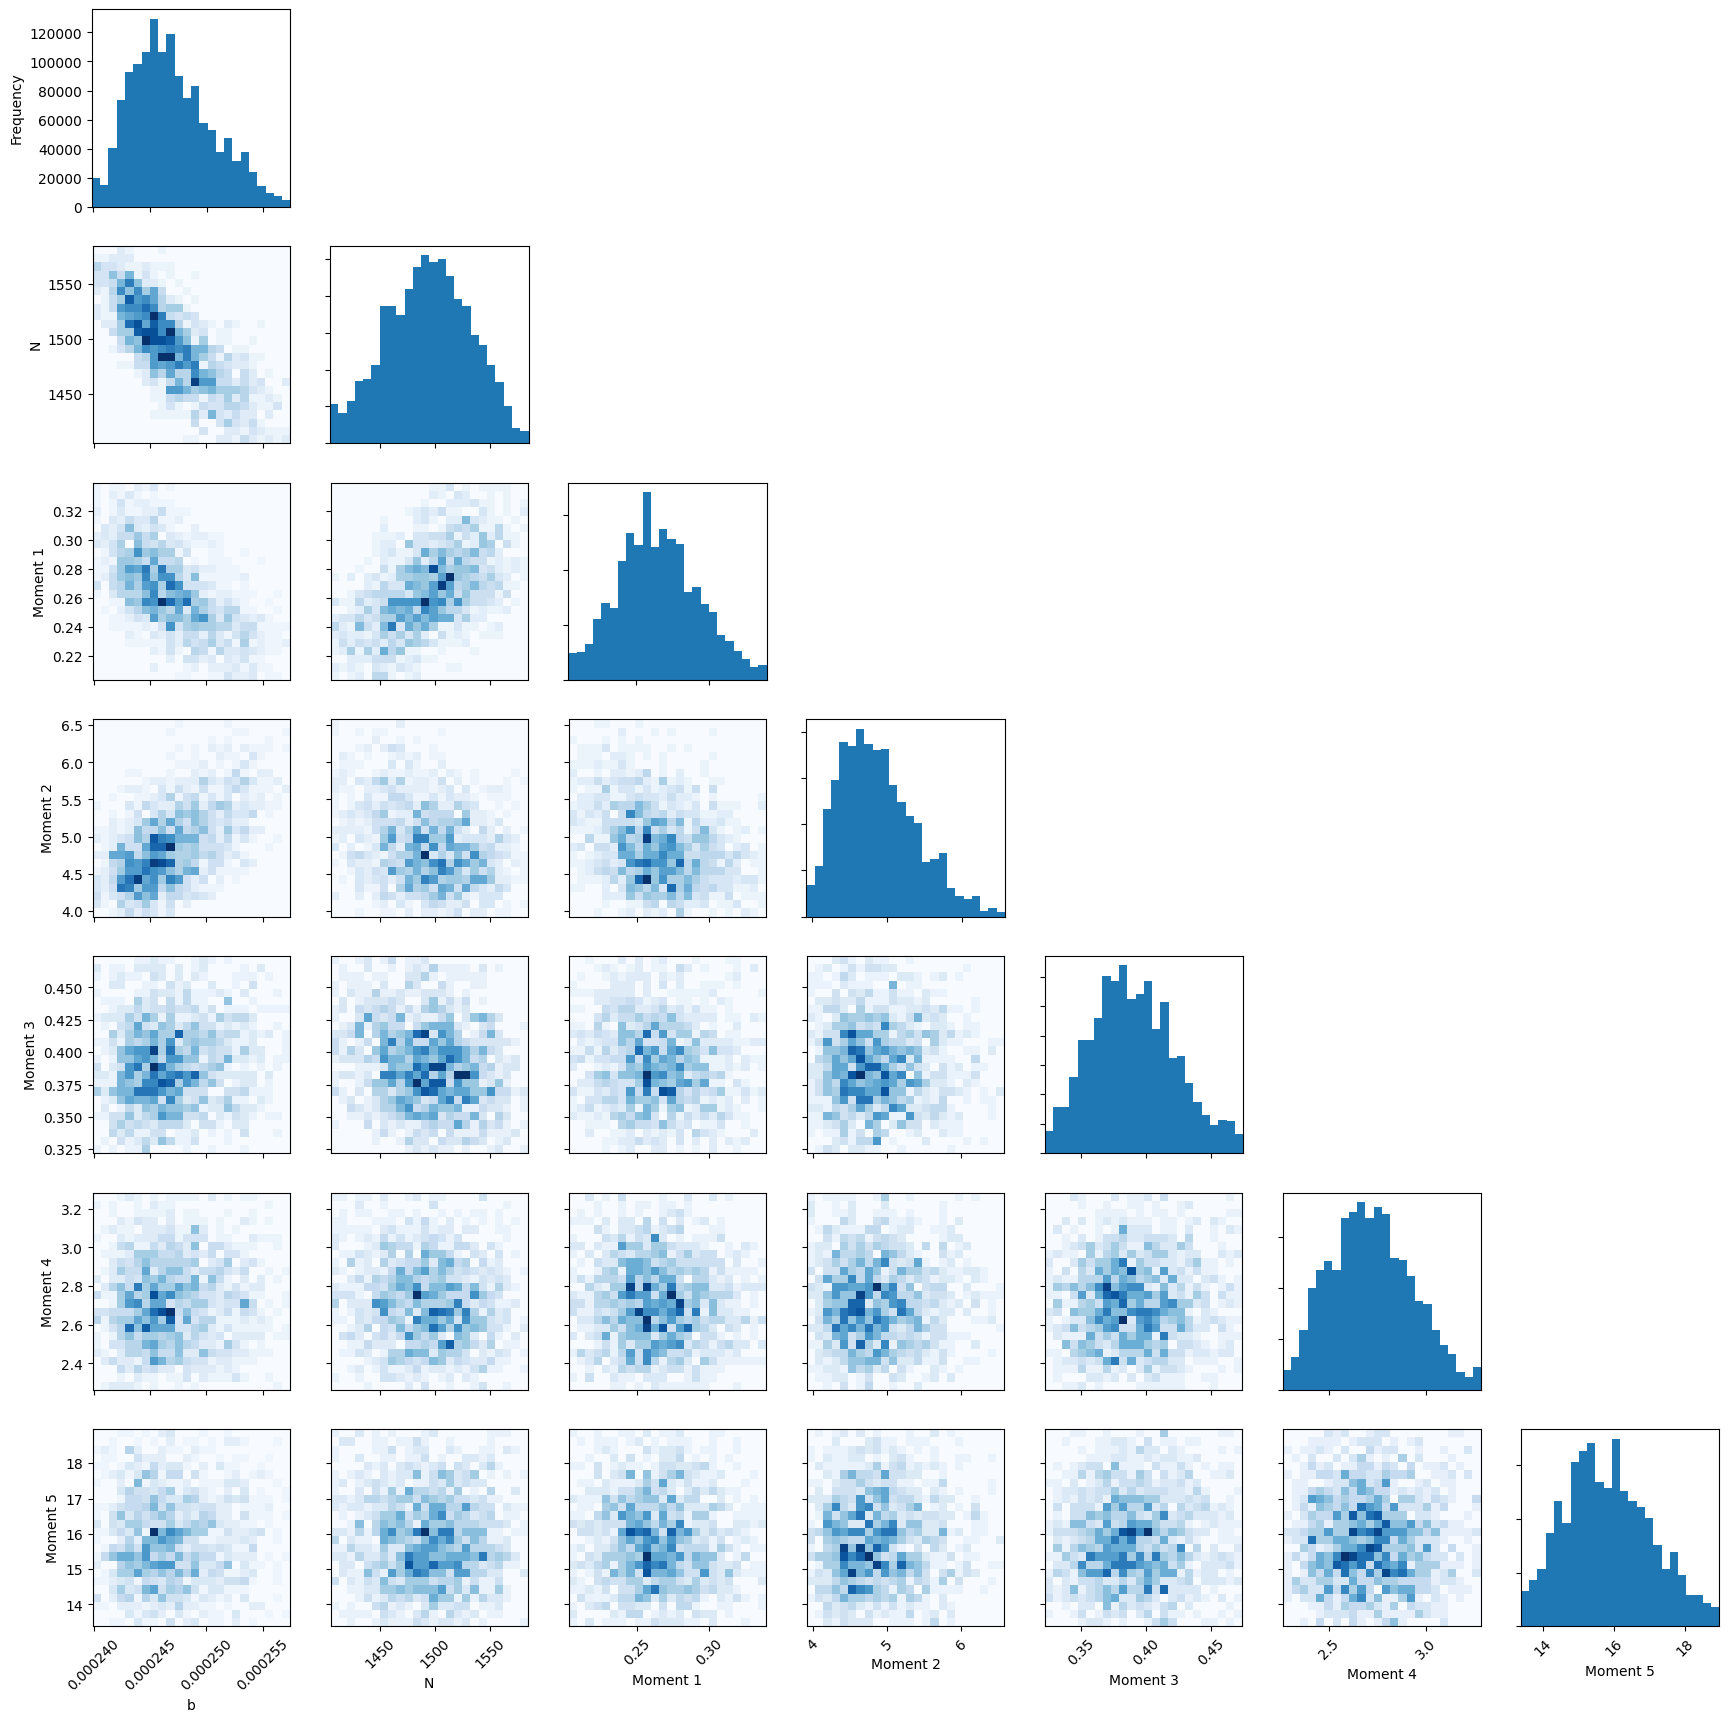

In [26]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[2.47383658e-04 1.50121830e+03 2.79642776e-01 5.53365404e+00
 3.62598131e-01 2.76647959e+00 1.63517975e+01]


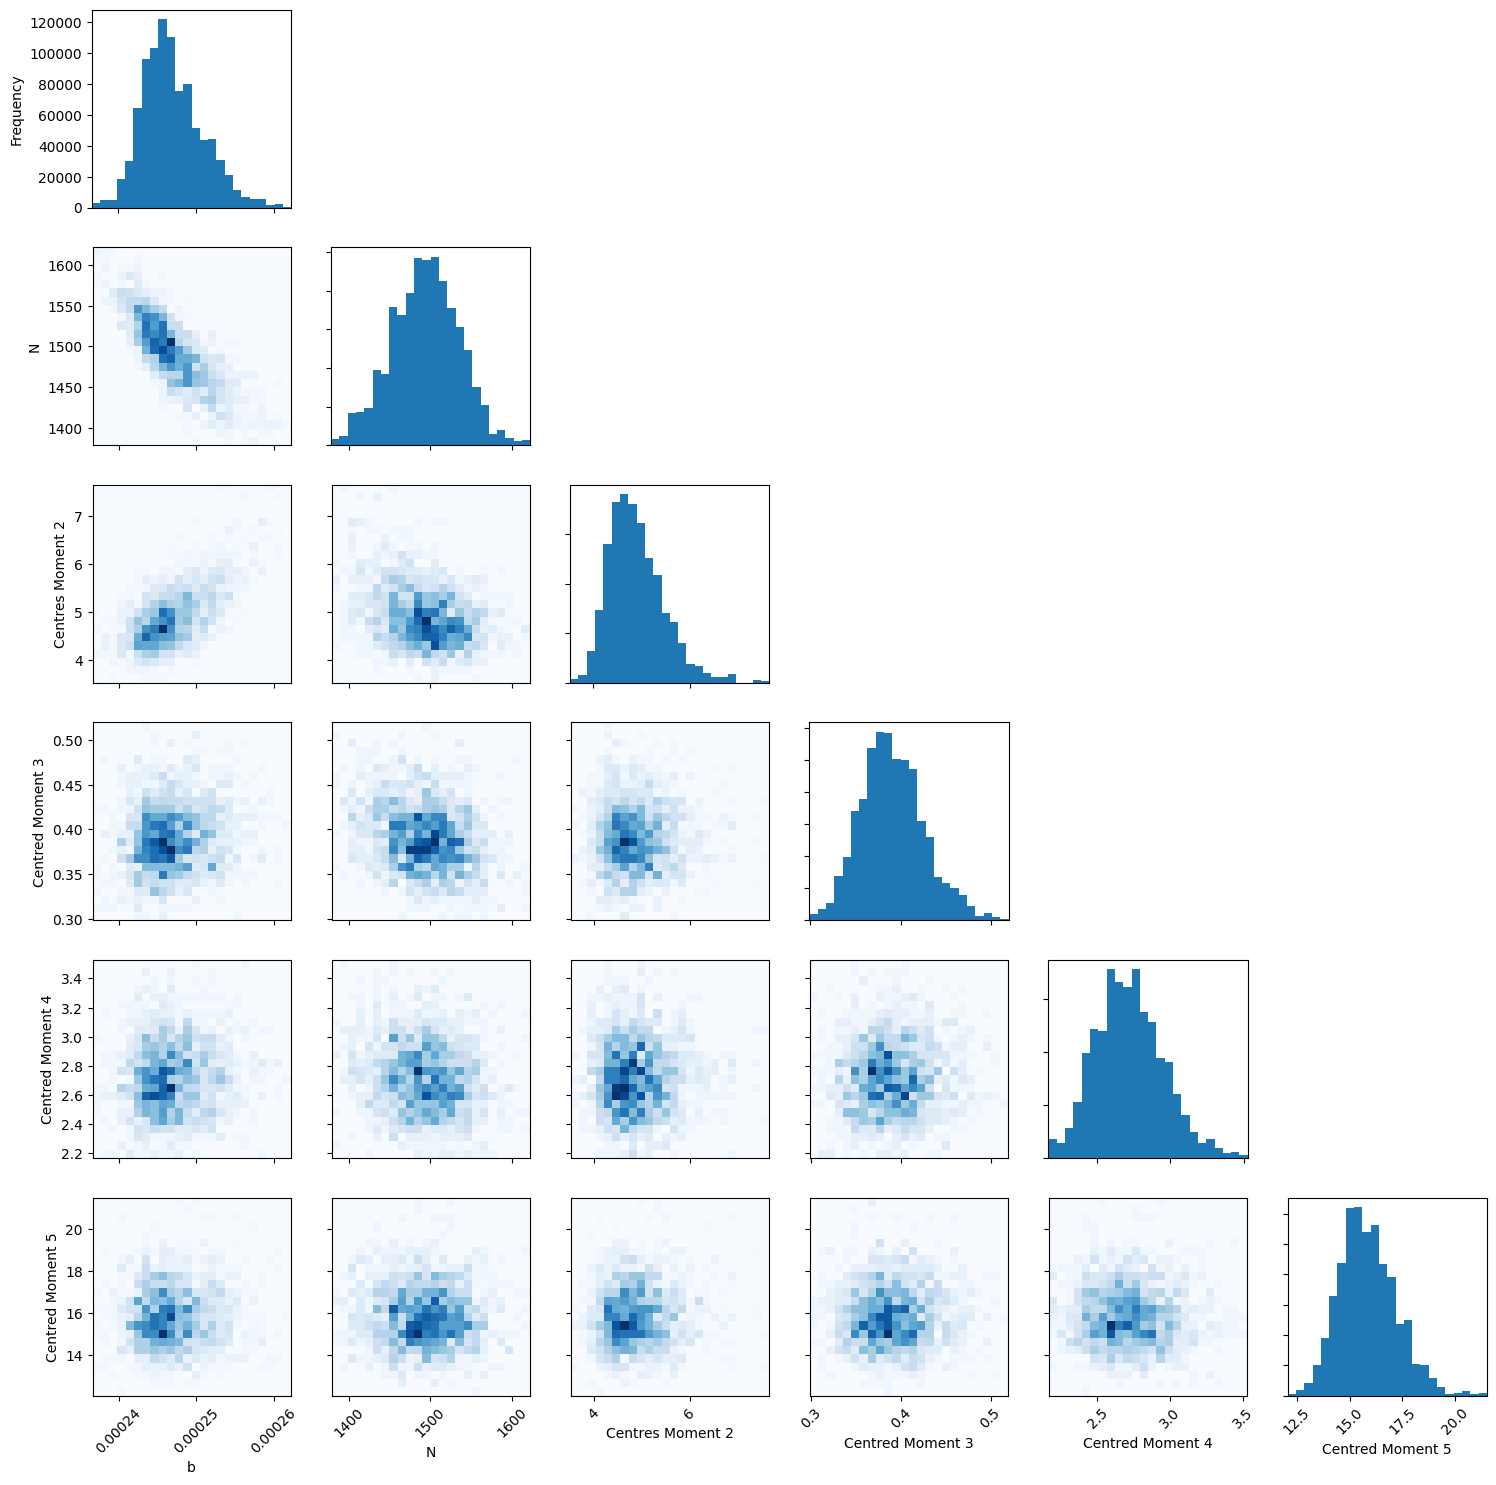

In [27]:
parameter_names = ["b","N", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5,6]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4", "Centred Moment 5"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [28]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess     ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  ------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.06    81.38   0.14
N         1493.95  42.81   1407.42  1463.58  1493.97  1524.87  1574.41  1.06    92.75   0.15
Moment 1  0.27     0.03    0.21     0.25     0.26     0.28     0.33     1.05    106.16  0.18
Moment 2  4.88     0.60    3.98     4.45     4.77     5.20     6.33     1.03    128.53  0.21
Moment 3  0.39     0.04    0.33     0.37     0.39     0.42     0.47     1.01    253.58  0.42
Moment 4  2.72     0.23    2.30     2.56     2.71     2.86     3.17     1.01    291.01  0.48
Moment 5  15.82    1.33    13.54    14.90    15.69    16.64    18.60    1.00    290.68  0.48


In [29]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [30]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000247  4.09e-06  0.00024   0.000244  0.000246  0.00025   0.000256  1.06    81.4   0.135
N         1.49e+03  42.8      1.41e+03  1.46e+03  1.49e+03  1.52e+03  1.57e+03  1.06    92.7   0.154
Moment 1  0.265     0.0307    0.207     0.245     0.263     0.284     0.331     1.05    106    0.176
Moment 2  4.88      0.604     3.98      4.45      4.77      5.2       6.33      1.03    129    0.213
Moment 3  0.391     0.0367    0.327     0.366     0.387     0.415     0.47      1.01    254    0.421
Moment 4  2.72      0.23      2.3       2.56      2.71      2.86      3.17      1.01    291    0.483
Moment 5  15.8      1.33      13.5      14.9      15.7      16.6      18.6      0.999   291    0.482


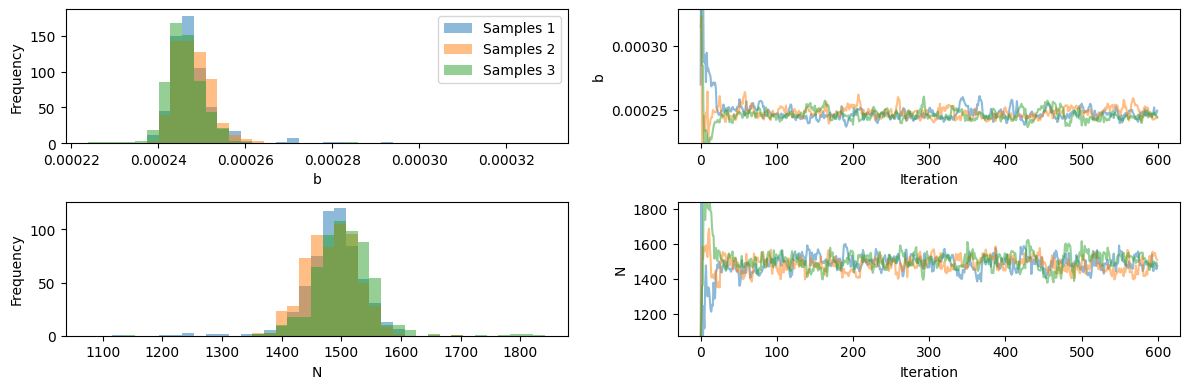

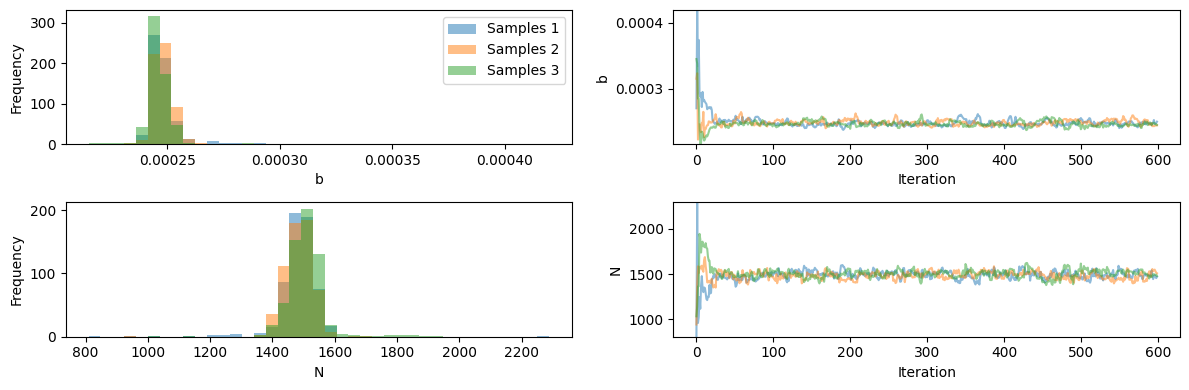

In [31]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()